For this competition, you are tasked with categorizing shopping trip types based on the items that customers purchased. To give a few hypothetical examples of trip types: a customer may make a small daily dinner trip, a weekly large grocery trip, a trip to buy gifts for an upcoming holiday, or a seasonal trip to buy clothes.

Walmart has categorized the trips contained in this data into 38 distinct types using a proprietary method applied to an extended set of data. You are challenged to recreate this categorization/clustering with a more limited set of features. This could provide new and more robust ways to categorize trips.

The training set (train.csv) contains a large number of customer visits with the TripType included. You must predict the TripType for each customer visit in the test set (test.csv). Each visit may only have one TripType. You will not be provided with more information than what is given in the data (e.g. what the TripTypes represent or more product information).

The test set file is encrypted. You must complete this brief survey to receive the password.

Data fields

TripType - a categorical id representing the type of shopping trip the customer made. This is the ground truth that you are predicting. TripType_999 is an "other" category.

VisitNumber - an id corresponding to a single trip by a single customer

Weekday - the weekday of the trip

Upc - the UPC number of the product purchased

ScanCount - the number of the given item that was purchased. A negative value indicates a product return.

DepartmentDescription - a high-level description of the item's department

FinelineNumber - a more refined category for each of the products, created by Walmart

In [53]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

from association_rules import AssociationRules
from scipy.sparse import *

convert_zeroes = True

### Read in Training Data

In [54]:
# Read in the training data from the file and load into a DataFrame
#df = pd.read_csv('train.csv')
df = pd.read_csv('train.csv', dtype={'VisitNumber': np.int32, 
                                       'Weekday': str, 
                                       'Upc': str, 
                                       'ScanCount': np.int16, 
                                       'DepartmentDescription': str, 
                                       'TripType': np.int8, 
                                       'FinelineNumber': np.float32})

# sort by VisitNumber to ensure everything is in the right order  
df = df.sort_values('VisitNumber')
df = df.reset_index()
del df['index']
df.head(5)

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,-25,5,Friday,68113152929,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,60538815980,1,SHOES,8931.0
2,30,7,Friday,7410811099,1,PERSONAL CARE,4504.0
3,26,8,Friday,NaN,1,NaN,NaN
4,26,8,Friday,3270011053,3,PETS AND SUPPLIES,1001.0


In [55]:
# check number of unique items per field
df.apply(lambda x: x.nunique(), axis=0)

TripType                    38
VisitNumber              95674
Weekday                      7
Upc                      97714
ScanCount                   39
DepartmentDescription       68
FinelineNumber            5195
dtype: int64

#### Check Null values

In [56]:
# Check for null values
df.isnull().sum(axis=0)

TripType                    0
VisitNumber                 0
Weekday                     0
Upc                      4129
ScanCount                   0
DepartmentDescription    1361
FinelineNumber           4129
dtype: int64

In [57]:
# Number of rows with nulls for Upc and FinelineNumber
my_filter = df['Upc'].isnull() & df['FinelineNumber'].isnull()
df[my_filter].shape[0]

4129

In [58]:
# DepartmentDescription where Upc and FinelineNumber is null
df[my_filter].groupby(['DepartmentDescription'], as_index=False)['ScanCount'].count()

,DepartmentDescription,ScanCount
0,PHARMACY RX,2768


In [59]:
# How many units normally purchased or returned?
df[my_filter].groupby(['DepartmentDescription','ScanCount'], as_index=False)['TripType'].count()

,DepartmentDescription,ScanCount,TripType
0,PHARMACY RX,-1,67
1,PHARMACY RX,1,2697
2,PHARMACY RX,2,4


In [60]:
# Are the nulls typically associated with a given trip type? Mostly TripType5 
df[my_filter].groupby(['TripType'], as_index=False)['ScanCount'].count().sort_values('ScanCount',ascending=False).head()

,TripType,ScanCount
3,5,2583
0,-25,352
31,40,193
30,39,135
16,25,116


In [61]:
df[df['TripType']==5].groupby(['DepartmentDescription'], as_index=False)['ScanCount'].count().sort_values('ScanCount',ascending=False).head(15)

,DepartmentDescription,ScanCount
47,PHARMACY OTC,5281
48,PHARMACY RX,2714
45,PERSONAL CARE,922
16,DSD GROCERY,614
29,IMPULSE MERCHANDISE,519
51,PRODUCE,435
42,OPTICAL - FRAMES,396
22,GROCERY DRY GOODS,384
15,DAIRY,237
5,BEAUTY,232


In [62]:
# Other nulls are fairly broadly distributed across trip types
my_filter = df['Upc'].isnull() & df['FinelineNumber'].isnull() & df['DepartmentDescription'].isnull()
df[my_filter].groupby(['TripType'], as_index=False)['ScanCount'].count()

,TripType,ScanCount
0,-25,247
1,3,5
2,4,1
3,5,13
4,6,3
5,7,29
6,8,68
7,9,79
8,12,4
9,15,21


In [63]:
# Replace nulls will 'Unknown' product categories
df['Upc'] = df['Upc'].fillna('UnknownUpc')
df['DepartmentDescription'] = df['DepartmentDescription'].fillna('UnknownDD')
df['FinelineNumber'] = df['FinelineNumber'].fillna('UnknownFN')
df.isnull().sum(axis=0)

TripType                 0
VisitNumber              0
Weekday                  0
Upc                      0
ScanCount                0
DepartmentDescription    0
FinelineNumber           0
dtype: int64

In [64]:
df.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,-25,5,Friday,68113152929,-1,FINANCIAL SERVICES,1000
1,30,7,Friday,60538815980,1,SHOES,8931
2,30,7,Friday,7410811099,1,PERSONAL CARE,4504
3,26,8,Friday,UnknownUpc,1,UnknownDD,UnknownFN
4,26,8,Friday,3270011053,3,PETS AND SUPPLIES,1001


### Read in Test Data

In [65]:
# Read in test data from the file and load into a DataFrame
# Note that it does not have the field TripType which is what we are trying to predict
dft = pd.read_csv('test.csv')
# sort by VisitNumber to ensure everything is in the right order  
dft = dft.sort_values('VisitNumber')
dft = dft.reset_index()
del dft['index']
dft.head(5)

,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,1,Friday,7.250339e+10,1,SHOES,3002.0
1,1,Friday,1.707711e+09,1,DAIRY,1526.0
2,1,Friday,8.947000e+10,1,DAIRY,1431.0
3,1,Friday,8.849121e+10,1,GROCERY DRY GOODS,3555.0
4,2,Friday,2.840015e+09,1,DSD GROCERY,4408.0


In [66]:
# Check number of unique items per field
dft.apply(lambda x: x.nunique(), axis=0)

VisitNumber              95674
Weekday                      7
Upc                      98147
ScanCount                   49
DepartmentDescription       67
FinelineNumber            5203
dtype: int64

In [67]:
# Check for null values
dft.isnull().sum(axis=0)

VisitNumber                 0
Weekday                     0
Upc                      3986
ScanCount                   0
DepartmentDescription    1328
FinelineNumber           3986
dtype: int64

In [68]:
# Replace nulls will 'Unknown' product categories
dft['Upc'] = dft['Upc'].fillna('UnknownUpc')
dft['DepartmentDescription'] = dft['DepartmentDescription'].fillna('UnknownDD')
dft['FinelineNumber'] = dft['FinelineNumber'].fillna('UnknownFN')
dft.isnull().sum(axis=0)

VisitNumber              0
Weekday                  0
Upc                      0
ScanCount                0
DepartmentDescription    0
FinelineNumber           0
dtype: int64

In [69]:
# Create a group of field headers that include categories from both the training and the test data sets
VisitNumber_u = list(sorted(df.VisitNumber.unique()))
VisitNumber_ut = list(sorted(dft.VisitNumber.unique()))

Upc_u = list(sorted(df.Upc.unique()))
Upc_ut = list(sorted(dft.Upc.unique()))
Upc_all = sorted(list(set(Upc_u)|set(Upc_ut)))

FN_u = list(sorted(df.FinelineNumber.unique()))
FN_ut = list(sorted(dft.FinelineNumber.unique()))
FN_all = sorted(list(set(FN_u)|set(FN_ut)))

DD_u = list(sorted(df.DepartmentDescription.unique()))
DD_ut = list(sorted(dft.DepartmentDescription.unique()))
DD_all = sorted(list(set(DD_u)|set(DD_ut)))


### Feature creation on the training data

In [70]:
# Convert Weekday from a text variable to a numerical variable
df['Weekday'] = df['Weekday'].map({'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7})
df.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,-25,5,5,68113152929,-1,FINANCIAL SERVICES,1000
1,30,7,5,60538815980,1,SHOES,8931
2,30,7,5,7410811099,1,PERSONAL CARE,4504
3,26,8,5,UnknownUpc,1,UnknownDD,UnknownFN
4,26,8,5,3270011053,3,PETS AND SUPPLIES,1001


In [71]:
# Create a variable to identify whether a return occurred or not
df['Return'] = np.where(df['ScanCount'] > 0, 0, 1)
df.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,Return
0,-25,5,5,68113152929,-1,FINANCIAL SERVICES,1000,1
1,30,7,5,60538815980,1,SHOES,8931,0
2,30,7,5,7410811099,1,PERSONAL CARE,4504,0
3,26,8,5,UnknownUpc,1,UnknownDD,UnknownFN,0
4,26,8,5,3270011053,3,PETS AND SUPPLIES,1001,0


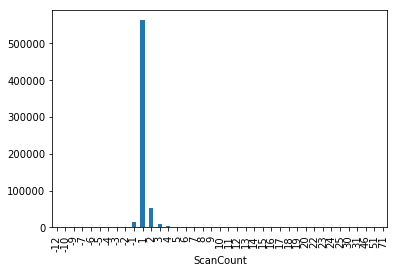

In [72]:
# Plot histogram of ScanCount
scancount_bar = df.groupby(['ScanCount'], as_index=False)['TripType'].count()
scancount_bar.plot.bar('ScanCount','TripType', legend=False)

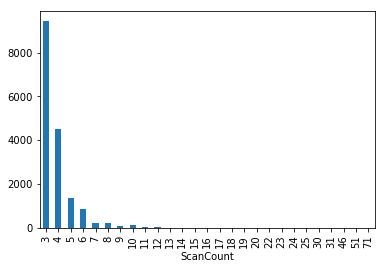

In [73]:
# Plot histogram of ScanCount where ScanCount>2
scancount3_bar = df[df['ScanCount']>2].groupby(['ScanCount'], as_index=False)['TripType'].count()
scancount3_bar.plot.bar('ScanCount','TripType', legend=False)

In [74]:
# Convert ScanCount negatives to 0's for MultinomialNB
if convert_zeroes:
    df['ScanCount'] = np.where(df['ScanCount'] < 0 , 0, df['ScanCount'])
df.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,Return
0,-25,5,5,68113152929,0,FINANCIAL SERVICES,1000,1
1,30,7,5,60538815980,1,SHOES,8931,0
2,30,7,5,7410811099,1,PERSONAL CARE,4504,0
3,26,8,5,UnknownUpc,1,UnknownDD,UnknownFN,0
4,26,8,5,3270011053,3,PETS AND SUPPLIES,1001,0


In [75]:
# Aggregate number of items by Department Description, i.e. sum ScanCount
dd = df.groupby(['VisitNumber','DepartmentDescription'], as_index=False)['ScanCount'].sum()
dd = dd.rename(columns={'ScanCount': 'ItemsDD'})
df = pd.merge(left=df, right=dd, on=['VisitNumber','DepartmentDescription'], how='left')
df.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,Return,ItemsDD
0,-25,5,5,68113152929,0,FINANCIAL SERVICES,1000,1,0
1,30,7,5,60538815980,1,SHOES,8931,0,1
2,30,7,5,7410811099,1,PERSONAL CARE,4504,0,1
3,26,8,5,UnknownUpc,1,UnknownDD,UnknownFN,0,1
4,26,8,5,3270011053,3,PETS AND SUPPLIES,1001,0,4


In [76]:
# Aggregate number of items by FinelineNumber, i.e. sum ScanCount
fn = df.groupby(['VisitNumber','FinelineNumber'], as_index=False)['ScanCount'].sum()
fn = fn.rename(columns={'ScanCount': 'ItemsFN'})
df = pd.merge(left=df, right=fn, on=['VisitNumber','FinelineNumber'], how='left')
df.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,Return,ItemsDD,ItemsFN
0,-25,5,5,68113152929,0,FINANCIAL SERVICES,1000,1,0,0
1,30,7,5,60538815980,1,SHOES,8931,0,1,1
2,30,7,5,7410811099,1,PERSONAL CARE,4504,0,1,1
3,26,8,5,UnknownUpc,1,UnknownDD,UnknownFN,0,1,1
4,26,8,5,3270011053,3,PETS AND SUPPLIES,1001,0,4,3


In [77]:
# Aggregate number of products by VisitNumber, i.e. count TripType
wd = df.groupby(['VisitNumber','Weekday'], as_index=False)['TripType'].count()
wd = wd.rename(columns={'TripType': 'NumProducts'})
df = pd.merge(left=df, right=wd, on=['VisitNumber','Weekday'], how='left')
df.head(5)

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,Return,ItemsDD,ItemsFN,NumProducts
0,-25,5,5,68113152929,0,FINANCIAL SERVICES,1000,1,0,0,1
1,30,7,5,60538815980,1,SHOES,8931,0,1,1,2
2,30,7,5,7410811099,1,PERSONAL CARE,4504,0,1,1,2
3,26,8,5,UnknownUpc,1,UnknownDD,UnknownFN,0,1,1,23
4,26,8,5,3270011053,3,PETS AND SUPPLIES,1001,0,4,3,23


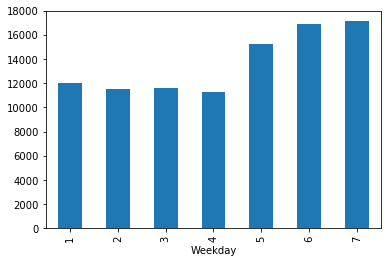

In [78]:
# Plot Weekday histogram
weekday_hist = wd.groupby(['Weekday'], as_index=False)['VisitNumber'].count()
weekday_hist.plot.bar('Weekday','VisitNumber', legend=False)

In [79]:
# Create a return dummy for each shopping visit
rt = df.groupby(['VisitNumber','TripType'], as_index=False)['Return'].sum()
rt['Return'] = np.where(rt['Return'] > 0 , 1, 0)
rt.head(5)

,VisitNumber,TripType,Return
0,5,-25,1
1,7,30,0
2,8,26,1
3,9,8,0
4,10,8,0


In [174]:
# Aggregate number of items by VisitNumber, i.e sum ScanCount
tt = df.groupby(['VisitNumber','TripType'], as_index=False)['ScanCount'].sum()
tt = tt.rename(columns={'ScanCount': 'NumItems'})
df = pd.merge(left=df, right=tt, on=['VisitNumber','TripType'], how='left')
df.head(5)

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,Return,ItemsDD,ItemsFN,NumProducts,NumItems_x,NumItems_y
0,-25,5,5,68113152929,0,FINANCIAL SERVICES,1000,1,0,0,1,0,0
1,30,7,5,60538815980,1,SHOES,8931,0,1,1,2,2,2
2,30,7,5,7410811099,1,PERSONAL CARE,4504,0,1,1,2,2,2
3,26,8,5,UnknownUpc,1,UnknownDD,UnknownFN,0,1,1,23,30,30
4,26,8,5,3270011053,3,PETS AND SUPPLIES,1001,0,4,3,23,30,30


In [175]:
# Sort by VisitNumber to get and ordered target list of TripType and row names of VisitNumber
tt['NumProducts'] = wd.NumProducts
tt['Return'] = rt.Return
tt.sort_values('VisitNumber')
aggs = tt[['NumItems', 'NumProducts', 'Return']]
tt.head()

,VisitNumber,TripType,NumItems,NumProducts,Return
0,5,-25,0,1,1
1,7,30,2,2,0
2,8,26,30,23,1
3,9,8,3,3,0
4,10,8,3,3,0


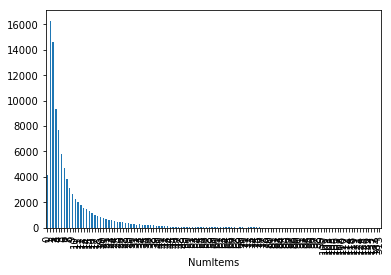

In [176]:
numitems_bar = tt.groupby(['NumItems'], as_index=False)['TripType'].count()
numitems_bar.plot.bar('NumItems','TripType', legend=False)
# numitems_bar.plot.bar('NumItems','TripType', legend=False, xticks=50)

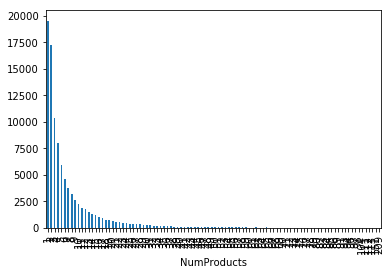

In [177]:
numproducts_bar = tt.groupby(['NumProducts'], as_index=False)['TripType'].count()
numproducts_bar.plot.bar('NumProducts','TripType', legend=False)
# numproducts_bar.plot.bar('NumProducts','TripType', legend=False, xticks=50)


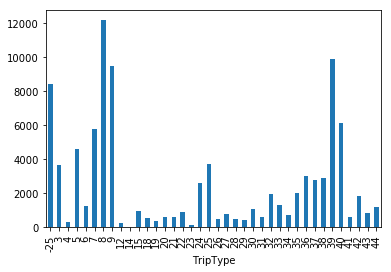

In [178]:
# Plot histogram of TripType
triptype_bar = tt.groupby(['TripType'], as_index=False)['NumItems'].count()
triptype_bar.plot.bar('TripType','NumItems', legend=False)


In [179]:
triptype_bar

,TripType,NumItems
0,-25,8444
1,3,3643
2,4,346
3,5,4593
4,6,1277
5,7,5752
6,8,12161
7,9,9464
8,12,269
9,14,4


In [180]:
target = tt.TripType
target.head()

0   -25
1    30
2    26
3     8
4     8
Name: TripType, dtype: int64

In [181]:
visit_numbers = tt.VisitNumber
visit_numbers.head()

0     5
1     7
2     8
3     9
4    10
Name: VisitNumber, dtype: int64

In [182]:
# calculate the most common association rules for the dataframe
ar = AssociationRules()
ar.fit(df)

# rules contain itemset bigrams and their predicted class and probabilities
rules = ar.transform(df)

# get only the best of the best
rules = rules[(rules['Confidence'] > 0.8) & (rules['VisitCount'] >= 2)].sort_values(['VisitCount' ], ascending=False).reset_index()

initializing...
(12976, 3)
(100,)
Checking Itemset 100...


In [183]:
# group data by visitnumber and make a set out of its items
itemsets = df.groupby('VisitNumber')['Upc'].apply(frozenset)

In [184]:
rules_set = set(rules['ItemSet'].tolist())
rules_list_u = sorted(rules.ItemSet.unique().tolist())
# determine which visits in the dataset contain these combinations
x = itemsets.apply(lambda x: x in rules_set)


In [185]:
# Create a sparse matrix boolean for whether each of these rules exists in a visit 
row = pd.Series(itemsets[x].index).astype('category', categories=VisitNumber_u).cat.codes
col = itemsets[x].astype('category', categories=rules_list_u).cat.codes
data = x[x]
AR_sm = csr_matrix((data, (row, col)), shape=(len(VisitNumber_u), len(rules_list_u)))
AR_sm

<95674x67 sparse matrix of type '<type 'numpy.bool_'>'
	with 3263 stored elements in Compressed Sparse Row format>

In [186]:
# Create a sparse matrix of Weekday dummies for VisitNumber
Weekday_u = list(sorted(wd.Weekday.unique()))
data = wd['Weekday'].tolist()
row = wd.VisitNumber.astype('category', categories=VisitNumber_u).cat.codes
col = wd.Weekday.astype('category', categories=Weekday_u).cat.codes
Weekday_sm = csr_matrix((data, (row, col)), shape=(len(VisitNumber_u), len(Weekday_u)))
Weekday_sm

<95674x7 sparse matrix of type '<type 'numpy.int64'>'
	with 95674 stored elements in Compressed Sparse Row format>

In [187]:
# Create a sparse matrix of number of items by Upc for each VisitNumber
data = df['ScanCount'].tolist()
row = df.VisitNumber.astype('category', categories=VisitNumber_u).cat.codes
col = df.Upc.astype('category', categories=Upc_all).cat.codes
Upc_sm = csr_matrix((data, (row, col)), shape=(len(VisitNumber_u), len(Upc_all)))
Upc_sm


<95674x195862 sparse matrix of type '<type 'numpy.int64'>'
	with 631237 stored elements in Compressed Sparse Row format>

In [188]:
# Create a sparse matrix of number of items by FinelineNumber for each VisitNumber
data = df['ItemsFN'].tolist()
row = df.VisitNumber.astype('category', categories=VisitNumber_u).cat.codes
col = df.FinelineNumber.astype('category', categories=FN_all).cat.codes
FN_sm = csr_matrix((data, (row, col)), shape=(len(VisitNumber_u), len(FN_all)))
FN_sm

<95674x5354 sparse matrix of type '<type 'numpy.int64'>'
	with 565525 stored elements in Compressed Sparse Row format>

In [189]:
# Create a sparse matrix of number of items by DepartmentDescription for each VisitNumber
data = df['ItemsDD'].tolist()
row = df.VisitNumber.astype('category', categories=VisitNumber_u).cat.codes
col = df.DepartmentDescription.astype('category', categories=DD_all).cat.codes
DD_sm = csr_matrix((data, (row, col)), shape=(len(VisitNumber_u), len(DD_all)))
DD_sm

<95674x69 sparse matrix of type '<type 'numpy.int64'>'
	with 322129 stored elements in Compressed Sparse Row format>

In [190]:
# Create a sparse matrix of the high level aggregate features
aggs_u = ['NumItems', 'NumProducts', 'Return']
aggs_sm = csr_matrix(aggs.values)
aggs_sm

<95674x3 sparse matrix of type '<type 'numpy.int64'>'
	with 198298 stored elements in Compressed Sparse Row format>

In [191]:
# Create column header lists because the sparse matrices are feature values only
col_names_m = aggs_u + Weekday_u + [str(i)+"Upc" for i in Upc_all] + [str(i)+"FN" for i in FN_all] + DD_all
col_names_l = aggs_u + Weekday_u + DD_all + [tuple(i) for i in rules_list_u]
len(col_names_m)

201295

In [192]:
# Horizontally stack the different feature blocks
sm_m = hstack(blocks=[aggs_sm,Weekday_sm,Upc_sm,FN_sm,DD_sm,AR_sm],format='csr')
sm_l = hstack(blocks=[aggs_sm,Weekday_sm,DD_sm,AR_sm],format='csr')
print sm_m.shape
print sm_l.shape

(95674, 201362)
(95674, 146)


### Feature creation on the test data

In [193]:
# Convert Weekday text variable to numerical
dft['Weekday'] = dft['Weekday'].map({'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7})
dft.head()

,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,Return,ItemsDD_x,ItemsFN_x,NumProducts_x,NumItems_x,ItemsDD_y,ItemsFN_y,NumProducts_y,NumItems_y,NumItems
0,1,NaN,7.25034e+10,1,SHOES,3002,0,1,1,4,4,1,1,NaN,4,4
1,1,NaN,1.70771e+09,1,DAIRY,1526,0,2,1,4,4,2,1,NaN,4,4
2,1,NaN,8.947e+10,1,DAIRY,1431,0,2,1,4,4,2,1,NaN,4,4
3,1,NaN,8.84912e+10,1,GROCERY DRY GOODS,3555,0,1,1,4,4,1,1,NaN,4,4
4,2,NaN,2.84002e+09,1,DSD GROCERY,4408,0,1,1,4,4,1,1,NaN,4,4


In [194]:
# Show there are no new department descriptions in the test data set
DD_train = list(df.DepartmentDescription.unique())
DD_test = list(dft.DepartmentDescription.unique())
DD_diff = [i for i in DD_test if i not in DD_train]
print "Items in test, but not in train:", DD_diff

Items in test, but not in train: []


In [195]:
# Show there are a large number of FinelineNumber's in the test data set that are not in the train data set
FN_train = list(df.FinelineNumber.unique())
FN_test = list(dft.FinelineNumber.unique())
FN_diff = [i for i in FN_test if i not in FN_train]
print "Item number in test, but not in train:", FN_diff
print "Number of items in test, but not in train:", len(FN_diff)


Item number in test, but not in train: [8308.0, 5418.0, 5306.0, 8702.0, 797.0, 1479.0, 3048.0, 2292.0, 5493.0, 5368.0, 5369.0, 9865.0, 3244.0, 8060.0, 187.0, 1038.0, 2480.0, 3612.0, 5546.0, 5590.0, 6449.0, 7242.0, 186.0, 5355.0, 743.0, 9894.0, 6299.0, 9818.0, 7505.0, 7214.0, 1143.0, 9940.0, 6314.0, 7678.0, 1024.0, 8872.0, 7381.0, 1263.0, 3134.0, 9314.0, 2374.0, 1068.0, 6599.0, 9122.0, 3241.0, 9171.0, 1931.0, 6096.0, 3236.0, 6553.0, 964.0, 9811.0, 2566.0, 6781.0, 646.0, 1055.0, 7679.0, 546.0, 9895.0, 1429.0, 852.0, 8309.0, 751.0, 1124.0, 573.0, 6746.0, 8585.0, 9817.0, 2970.0, 5911.0, 7915.0, 7338.0, 6356.0, 3278.0, 1519.0, 9027.0, 1596.0, 1126.0, 6214.0, 2727.0, 4527.0, 4713.0, 4449.0, 8974.0, 7709.0, 798.0, 4448.0, 9015.0, 1461.0, 6107.0, 7412.0, 489.0, 3696.0, 9291.0, 2213.0, 7069.0, 8932.0, 828.0, 2578.0, 1492.0, 7234.0, 6063.0, 7620.0, 8412.0, 2770.0, 6358.0, 7154.0, 480.0, 7405.0, 3843.0, 9945.0, 746.0, 3653.0, 1713.0, 1054.0, 92.0, 5091.0, 2336.0, 9019.0, 7039.0, 6385.0, 3289.0, 3

In [196]:
df[df['FinelineNumber'] == 8308]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,Return,ItemsDD,ItemsFN,NumProducts,NumItems_x,NumItems_y


In [197]:
dft[dft['FinelineNumber'] == 8308]

,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,Return,ItemsDD_x,ItemsFN_x,NumProducts_x,NumItems_x,ItemsDD_y,ItemsFN_y,NumProducts_y,NumItems_y,NumItems
1307,555,NaN,8.15419e+10,1,SPORTING GOODS,8308,0,1,1,6,6,1,1,NaN,6,6


In [198]:
# Create a return dummy
dft['Return'] = np.where(dft['ScanCount'] > 0, 0 , 1)
dft.head()

,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,Return,ItemsDD_x,ItemsFN_x,NumProducts_x,NumItems_x,ItemsDD_y,ItemsFN_y,NumProducts_y,NumItems_y,NumItems
0,1,NaN,7.25034e+10,1,SHOES,3002,0,1,1,4,4,1,1,NaN,4,4
1,1,NaN,1.70771e+09,1,DAIRY,1526,0,2,1,4,4,2,1,NaN,4,4
2,1,NaN,8.947e+10,1,DAIRY,1431,0,2,1,4,4,2,1,NaN,4,4
3,1,NaN,8.84912e+10,1,GROCERY DRY GOODS,3555,0,1,1,4,4,1,1,NaN,4,4
4,2,NaN,2.84002e+09,1,DSD GROCERY,4408,0,1,1,4,4,1,1,NaN,4,4


In [199]:
# Convert ScanCount negatives to 0's
if convert_zeroes:
    dft['ScanCount'] = np.where(dft['ScanCount'] < 0 , 0, dft['ScanCount'])
    dft.head()

In [200]:
# Aggregate number of items by Department Description, i.e. sum ScanCount
ddt = dft.groupby(['VisitNumber','DepartmentDescription'], as_index=False)['ScanCount'].sum()
ddt = ddt.rename(columns={'ScanCount': 'ItemsDD'})
dft = pd.merge(left=dft, right=ddt, on=['VisitNumber','DepartmentDescription'], how='left')
dft.head()


,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,Return,ItemsDD_x,ItemsFN_x,NumProducts_x,NumItems_x,ItemsDD_y,ItemsFN_y,NumProducts_y,NumItems_y,NumItems,ItemsDD
0,1,NaN,7.25034e+10,1,SHOES,3002,0,1,1,4,4,1,1,NaN,4,4,1
1,1,NaN,1.70771e+09,1,DAIRY,1526,0,2,1,4,4,2,1,NaN,4,4,2
2,1,NaN,8.947e+10,1,DAIRY,1431,0,2,1,4,4,2,1,NaN,4,4,2
3,1,NaN,8.84912e+10,1,GROCERY DRY GOODS,3555,0,1,1,4,4,1,1,NaN,4,4,1
4,2,NaN,2.84002e+09,1,DSD GROCERY,4408,0,1,1,4,4,1,1,NaN,4,4,1


In [201]:
# Aggregate number of items by FinelineNumber, i.e. sum ScanCount
fnt = dft.groupby(['VisitNumber','FinelineNumber'], as_index=False)['ScanCount'].sum()
fnt = fnt.rename(columns={'ScanCount': 'ItemsFN'})
dft = pd.merge(left=dft, right=fnt, on=['VisitNumber','FinelineNumber'], how='left')
dft.head()

,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,Return,ItemsDD_x,ItemsFN_x,NumProducts_x,NumItems_x,ItemsDD_y,ItemsFN_y,NumProducts_y,NumItems_y,NumItems,ItemsDD,ItemsFN
0,1,NaN,7.25034e+10,1,SHOES,3002,0,1,1,4,4,1,1,NaN,4,4,1,1
1,1,NaN,1.70771e+09,1,DAIRY,1526,0,2,1,4,4,2,1,NaN,4,4,2,1
2,1,NaN,8.947e+10,1,DAIRY,1431,0,2,1,4,4,2,1,NaN,4,4,2,1
3,1,NaN,8.84912e+10,1,GROCERY DRY GOODS,3555,0,1,1,4,4,1,1,NaN,4,4,1,1
4,2,NaN,2.84002e+09,1,DSD GROCERY,4408,0,1,1,4,4,1,1,NaN,4,4,1,1


In [202]:
# Aggregate number of products by VisitNumber, i.e. count TripType
wdt = dft.groupby(['VisitNumber','Weekday'], as_index=False)['ScanCount'].count()
wdt = wdt.rename(columns={'ScanCount': 'NumProducts'})
dft = pd.merge(left=dft, right=wdt, on=['VisitNumber','Weekday'], how='left')
dft.head(5)

,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,Return,ItemsDD_x,ItemsFN_x,NumProducts_x,NumItems_x,ItemsDD_y,ItemsFN_y,NumProducts_y,NumItems_y,NumItems,ItemsDD,ItemsFN,NumProducts
0,1,NaN,7.25034e+10,1,SHOES,3002,0,1,1,4,4,1,1,NaN,4,4,1,1,NaN
1,1,NaN,1.70771e+09,1,DAIRY,1526,0,2,1,4,4,2,1,NaN,4,4,2,1,NaN
2,1,NaN,8.947e+10,1,DAIRY,1431,0,2,1,4,4,2,1,NaN,4,4,2,1,NaN
3,1,NaN,8.84912e+10,1,GROCERY DRY GOODS,3555,0,1,1,4,4,1,1,NaN,4,4,1,1,NaN
4,2,NaN,2.84002e+09,1,DSD GROCERY,4408,0,1,1,4,4,1,1,NaN,4,4,1,1,NaN


In [203]:
# Create a return dummy for each shopping visit
rtt = dft.groupby(['VisitNumber'], as_index=False)['Return'].sum()
rtt['Return'] = np.where(rtt['Return'] > 0 , 1, 0)
rtt.head(5)

,VisitNumber,Return
0,1,0
1,2,0
2,3,1
3,4,0
4,6,1


In [204]:
# Aggregate number of items by VisitNumber, i.e sum ScanCount
ttt = dft.groupby(['VisitNumber'], as_index=False)['ScanCount'].sum()
ttt = ttt.rename(columns={'ScanCount': 'NumItems'})
dft = pd.merge(left=dft, right=ttt, on=['VisitNumber'], how='left')
dft.head(10)

,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,Return,ItemsDD_x,ItemsFN_x,NumProducts_x,NumItems_x,ItemsDD_y,ItemsFN_y,NumProducts_y,NumItems_y,NumItems_x,ItemsDD,ItemsFN,NumProducts,NumItems_y
0,1,NaN,7.25034e+10,1,SHOES,3002,0,1,1,4,4,1,1,NaN,4,4,1,1,NaN,4
1,1,NaN,1.70771e+09,1,DAIRY,1526,0,2,1,4,4,2,1,NaN,4,4,2,1,NaN,4
2,1,NaN,8.947e+10,1,DAIRY,1431,0,2,1,4,4,2,1,NaN,4,4,2,1,NaN,4
3,1,NaN,8.84912e+10,1,GROCERY DRY GOODS,3555,0,1,1,4,4,1,1,NaN,4,4,1,1,NaN,4
4,2,NaN,2.84002e+09,1,DSD GROCERY,4408,0,1,1,4,4,1,1,NaN,4,4,1,1,NaN,4
5,2,NaN,7.87421e+09,1,BAKERY,5019,0,1,1,4,4,1,1,NaN,4,4,1,1,NaN,4
6,2,NaN,8.74586e+10,1,IMPULSE MERCHANDISE,8023,0,2,2,4,4,2,2,NaN,4,4,2,2,NaN,4
7,2,NaN,8.74586e+10,1,IMPULSE MERCHANDISE,8023,0,2,2,4,4,2,2,NaN,4,4,2,2,NaN,4
8,3,NaN,7.41081e+09,0,PERSONAL CARE,4504,1,1,1,2,1,1,1,NaN,1,1,1,1,NaN,1
9,3,NaN,7.41081e+09,1,PERSONAL CARE,4504,0,1,1,2,1,1,1,NaN,1,1,1,1,NaN,1


In [205]:
# Create sets from Upc itemsets by VisitNumber, ie. frozenset(Upc) 
# determine which visits in the dataset contain these combinations
itemsets = dft.groupby('VisitNumber')['Upc'].apply(frozenset)
rules_set = set(rules['ItemSet'].tolist())
rules_list_u = sorted(rules.ItemSet.unique().tolist())
xt = itemsets.apply(lambda x: x in rules_set)

In [206]:
# Combine aggregates and sort by VisitNumber to get ordered row names of VisitNumber
ttt['NumProducts'] = wdt.NumProducts
ttt['Return'] = rtt.Return
ttt.sort_values('VisitNumber')
aggs = ttt[['NumItems', 'NumProducts', 'Return']]
ttt.head()

,VisitNumber,NumItems,NumProducts,Return
0,1,4,NaN,0
1,2,4,NaN,0
2,3,1,NaN,1
3,4,1,NaN,0
4,6,1,NaN,1


In [207]:
visit_numberst = ttt.VisitNumber
visit_numberst.head()

0    1
1    2
2    3
3    4
4    6
Name: VisitNumber, dtype: int64

### Data Transformation

In [208]:
def feature_transformation(df, df_other, convert_zeroes=False):

    # Create a group of field headers that include categories from both the training and the test data sets
    VisitNumber_u = list(sorted(df.VisitNumber.unique()))
    VisitNumber_u_other = list(sorted(df_other.VisitNumber.unique()))

    Upc_u = list(sorted(df.Upc.unique()))
    Upc_u_other = list(sorted(df_other.Upc.unique()))
    Upc_all = sorted(list(set(Upc_u)|set(Upc_u_other)))

    FN_u = list(sorted(df.FinelineNumber.unique()))
    FN_u_other = list(sorted(df_other.FinelineNumber.unique()))
    FN_all = sorted(list(set(FN_u)|set(FN_u_other)))

    DD_u = list(sorted(df.DepartmentDescription.unique()))
    DD_u_other = list(sorted(df_other.DepartmentDescription.unique()))
    DD_all = sorted(list(set(DD_u)|set(DD_u_other)))
    
    # Replace nulls will 'Unknown' product categories
    df['Upc'] = df['Upc'].fillna('UnknownUpc')
    df['DepartmentDescription'] = df['DepartmentDescription'].fillna('UnknownDD')
    df['FinelineNumber'] = df['FinelineNumber'].fillna('UnknownFN')

    # Convert Weekday text variable to numerical
    df['Weekday'] = df['Weekday'].map({'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7})
 
    # Create a return dummy
    df['Return'] = np.where(df['ScanCount'] > 0, 0 , 1)

    # Convert ScanCount negatives to 0's
    if convert_zeroes:
        df['ScanCount'] = np.where(df['ScanCount'] < 0 , 0, df['ScanCount'])

    # Aggregate number of items by Department Description, i.e. sum ScanCount
    dd = df.groupby(['VisitNumber','DepartmentDescription'], as_index=False)['ScanCount'].sum()
    dd = dd.rename(columns={'ScanCount': 'ItemsDD'})
    df = pd.merge(left=df, right=dd, on=['VisitNumber','DepartmentDescription'], how='left')

    # Aggregate number of items by FinelineNumber, i.e. sum ScanCount
    fn = df.groupby(['VisitNumber','FinelineNumber'], as_index=False)['ScanCount'].sum()
    fn = fn.rename(columns={'ScanCount': 'ItemsFN'})
    df = pd.merge(left=df, right=fn, on=['VisitNumber','FinelineNumber'], how='left')        

    # Aggregate number of products by VisitNumber, i.e. count ScanCount
    wd = df.groupby(['VisitNumber','Weekday'], as_index=False)['ScanCount'].count()
    wd = wd.rename(columns={'ScanCount': 'NumProducts'})
    Weekday_u = list(sorted(wd.Weekday.unique()))
    df = pd.merge(left=df, right=wd, on=['VisitNumber','Weekday'], how='left')
    
    # Create a return dummy for each shopping visit
    rt = df.groupby(['VisitNumber'], as_index=False)['Return'].sum()
    rt['Return'] = np.where(rt['Return'] > 0 , 1, 0)

    # Aggregate number of items by VisitNumber, i.e sum ScanCount
    tt = df.groupby(['VisitNumber'], as_index=False)['ScanCount'].sum()
    tt = tt.rename(columns={'ScanCount': 'NumItems'})
    df = pd.merge(left=df, right=tt, on=['VisitNumber'], how='left')
    
    # Combine aggregates and sort by VisitNumber to get ordered row names of VisitNumber
    tt['NumProducts'] = wd.NumProducts
    tt['Return'] = rt.Return
    tt.sort_values('VisitNumber')
    aggs = tt[['NumItems', 'NumProducts', 'Return']] 

    # Isolate Visit Numbers
    visit_numbers = tt.VisitNumber
    
    # Create a sparse matrix boolean for whether the association rules exists in a visit 
    row = pd.Series(itemsets[xt].index).astype('category', categories=VisitNumber_u).cat.codes
    col = itemsets[xt].astype('category', categories=rules_list_u).cat.codes
    data = xt[xt]
    AR_sm = csr_matrix((data, (row, col)), shape=(len(VisitNumber_u), len(rules_list_u)))
    
    # Create a sparse matrix of Weekday dummies for VisitNumber
    data = wd['Weekday'].tolist()
    row = wd.VisitNumber.astype('category', categories=VisitNumber_u).cat.codes
    col = wd.Weekday.astype('category', categories=Weekday_u).cat.codes
    Weekday_sm = csr_matrix((data, (row, col)), shape=(len(VisitNumber_u), len(Weekday_u)))

    # Create a sparse matrix of number of items by Upc for each VisitNumber
    data = df['ScanCount'].tolist()
    row = df.VisitNumber.astype('category', categories=VisitNumber_u).cat.codes
    col = df.Upc.astype('category', categories=Upc_all).cat.codes
    Upc_sm = csr_matrix((data, (row, col)), shape=(len(VisitNumber_u), len(Upc_all)))

    # Create a sparse matrix of number of items by FinelineNumber for each VisitNumber
    data = df['ItemsFN'].tolist()
    row = df.VisitNumber.astype('category', categories=VisitNumber_u).cat.codes
    col = df.FinelineNumber.astype('category', categories=FN_all).cat.codes
    FN_sm = csr_matrix((data, (row, col)), shape=(len(VisitNumber_u), len(FN_all)))
    
    # Create a sparse matrix of number of items by DepartmentDescription for each VisitNumber
    data = df['ItemsDD'].tolist()
    row = df.VisitNumber.astype('category', categories=VisitNumber_u).cat.codes
    col = df.DepartmentDescription.astype('category', categories=DD_all).cat.codes
    DD_sm = csr_matrix((data, (row, col)), shape=(len(VisitNumber_u), len(DD_all)))

    # Create a sparse matrix of the high level aggregate features
    aggs_u = ['NumItems', 'NumProducts', 'Return']
    aggs_sm = csr_matrix(aggs.values)
    aggs_sm

    # Horizontally stack the blocks
    smt_m = hstack(blocks=[aggs_smt,Weekday_smt,Upc_smt,FN_smt,DD_smt,AR_sm],format='csr')
    smt_l = hstack(blocks=[aggs_smt,Weekday_smt,DD_smt,AR_sm],format='csr')
    print smt_m.shape
    print smt_l.shape


In [209]:
# Create a sparse matrix of Weekday dummies for VisitNumber
data = wdt['Weekday'].tolist()
row = wdt.VisitNumber.astype('category', categories=VisitNumber_ut).cat.codes
col = wdt.Weekday.astype('category', categories=Weekday_u).cat.codes
Weekday_smt = csr_matrix((data, (row, col)), shape=(len(VisitNumber_ut), len(Weekday_u)))
Weekday_smt

<95674x7 sparse matrix of type '<type 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [210]:
# Create a sparse matrix of number of items by Upc for each VisitNumber
data = dft['ScanCount'].tolist()
row = dft.VisitNumber.astype('category', categories=VisitNumber_ut).cat.codes
col = dft.Upc.astype('category', categories=Upc_all).cat.codes
Upc_smt = csr_matrix((data, (row, col)), shape=(len(VisitNumber_ut), len(Upc_all)))
Upc_smt

<95674x195862 sparse matrix of type '<type 'numpy.int64'>'
	with 637564 stored elements in Compressed Sparse Row format>

In [211]:
# Create a sparse matrix of number of items by FinelineNumber for each VisitNumber
data = dft['ItemsFN'].tolist()
row = dft.VisitNumber.astype('category', categories=VisitNumber_ut).cat.codes
col = dft.FinelineNumber.astype('category', categories=FN_all).cat.codes
FN_smt = csr_matrix((data, (row, col)), shape=(len(VisitNumber_ut), len(FN_all)))
FN_smt

<95674x5354 sparse matrix of type '<type 'numpy.int64'>'
	with 570069 stored elements in Compressed Sparse Row format>

In [212]:
# Create a sparse matrix of number of items by DepartmentDescription for each VisitNumber
data = dft['ItemsDD'].tolist()
row = dft.VisitNumber.astype('category', categories=VisitNumber_ut).cat.codes
col = dft.DepartmentDescription.astype('category', categories=DD_all).cat.codes
DD_smt = csr_matrix((data, (row, col)), shape=(len(VisitNumber_ut), len(DD_all)))
DD_smt

<95674x69 sparse matrix of type '<type 'numpy.int64'>'
	with 323632 stored elements in Compressed Sparse Row format>

In [213]:
# Create a sparse matrix of the high level aggregate features
aggs_u = ['NumItems', 'NumProducts', 'Return']
aggs_smt = csr_matrix(aggs.values)
aggs_smt

<95674x3 sparse matrix of type '<type 'numpy.float64'>'
	with 198433 stored elements in Compressed Sparse Row format>

In [214]:
# Horizontally stack the blocks
smt_m = hstack(blocks=[aggs_smt,Weekday_smt,Upc_smt,FN_smt,DD_smt],format='csr')
smt_l = hstack(blocks=[aggs_smt,Weekday_smt,DD_smt],format='csr')
print smt_m.shape
print smt_l.shape

(95674, 201295)
(95674, 79)


### Fit a model

Signature:

    metrics.log_loss(y_true, y_pred, eps=1e-15, normalize=True, sample_weight=None, labels=None)

Docstring: Log loss, aka logistic loss or **cross-entropy loss**.

This is the loss function used in (**multinomial**) logistic regression
and extensions of it such as **neural networks**, defined as the negative
log-likelihood of the true labels given a probabilistic classifier's
predictions. The log loss is only defined for two or more labels.
For a single sample with true label yt in {0,1} and
estimated probability yp that yt = 1, the log loss is

    -log P(yt|yp) = -(yt log(yp) + (1 - yt) log(1 - yp))

In the multiclass case, the training algorithm uses the one-vs-rest (OvR) scheme if the 'multi_class' option is set to 'ovr', and uses the **cross-entropy loss** if the **'multi_class'** option is set to **'multinomial'**. (Currently the **'multinomial'** option is supported only by the **'lbfgs'**,**'sag'** and **'newton-cg'** solvers.)

For multiclass problems, only solver= 'newton-cg', 'sag' and 'lbfgs' handle multinomial loss.

In [215]:
# Make a log-loss scorer for use in GridSearchCV
my_log_loss = metrics.make_scorer(metrics.log_loss, greater_is_better=False, needs_proba=True)

In [216]:
# Create list of trip type labels
trip_types = sorted(list(set(target)))
print "Trip type labels:", trip_types
print "Number of trip types:", len(trip_types)

Trip type labels: [-25, 3, 4, 5, 6, 7, 8, 9, 12, 14, 15, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
Number of trip types: 38


In [ ]:
# Choose the right sparse feature matrix for the classifier
train_features = sm_l
train_labels = target
test_features = smt_l
test_visit_numbers = visit_numberst
test_trip_types = trip_types

# Choose type of model run
single_classifier = True

# Fit model using a single classifier on training data sparse matrix (sm)
if single_classifier:
    # Set up classifier
    clf = LogisticRegression(C=1000,multi_class='multinomial',solver='newton-cg',n_jobs=-1,tol=1,max_iter=400,warm_start=True)
    
    # Fit grid search
    clf.fit(train_features,target)

# Fit model using GridSearchCV on the training data sparse matrix (sm)
else:
    # Set up classifier
    clf = MultinomialNB()
    # clf = LogisticRegression(C=1000,multi_class='multinomial',solver='newton-cg',n_jobs=-1,tol=1,max_iter=200,warm_start=True)
    # clf = LogisticRegression(C=10,multi_class='multinomial',solver='newton-cg',n_jobs=-1,tol=0.0001,max_iter=200,warm_start=True)

    # Set up grid search
    # gs = GridSearchCV(estimator=clf, param_grid={'alpha': [round(float(i)/100,2) for i in range(20,31)]},n_jobs=-1,cv=4)
    gs = GridSearchCV(estimator=clf, param_grid={'alpha': [round(float(i)/100,2) for i in range(20,31)]},n_jobs=-1,cv=4,scoring=my_log_loss)

    # Fit the grid search
    gs.fit(train_features,target) 

    # Report grid search results 
    print gs.grid_scores_
    print gs.best_estimator_
    print gs.best_score_
    print gs.best_params_


In [ ]:
# Set the classifier for reporting accuracy results 
if single_classifier:
    my_clf = clf
else:
    my_clf = gs

# Make predictions on the training data sparse matrix (sm)
train_preds = my_clf.predict(train_features) 

# Collect predicted probabilities
train_probs = my_clf.predict_proba(train_features)

# Report various accuracy metrics
print "Log loss:", round(metrics.log_loss(target,train_probs,eps=1e-15),3)
print "F1 score:", round(metrics.f1_score(target,train_preds,average='micro'),3)
print ""
print "Clasification Report:"
print classification_report(target,train_preds)
print ""
print "Summary confusion matrix:"
cm = confusion_matrix(target,train_preds)
for i in range(38):
    max_wrong = 0
    k = -1
    for j in range(38):
        if i != j:
            if cm[i][j] > max_wrong:
                k = j
                max_wrong = cm[i][j]
    print trip_types[i], trip_types[k], max_wrong 


In [ ]:
# generate probabilities for output
test_probs = my_clf.predict_proba(test_features) # make sure you are using the correct test data sparse matrix
test_probs.shape

In [ ]:
# Function to write probabilities to a csv file in the correct submission format
def write_probs_to_file(vn,tt,probs):
    # open file to write results
    with open("walmart.csv", "w") as results:
        # write header
        my_str = ""
        my_str += '"VisitNumber"' + "," 
        for trip_num in tt[:-1]:
            my_str += '"TripType_' + str(trip_num) + '"' + ","
        my_str += '"TripType_' + str(tt[-1]) + '"' + "\n" 
        results.write(my_str)
        # write probs for each visit
        for i in range(probs.shape[0]):
            my_str = ""
            my_str += str(vn[i]) + "," 
            for j in range(probs.shape[1]):
                my_str += str(probs[i][j]) + ","
            my_str = my_str[:-1] + "\n"
            results.write(my_str)



In [ ]:
write_probs_to_file(test_visit_numbers,test_trip_types,test_probs)
